In [19]:
import json, re
import pandas as pd
from PIL import Image
import requests
import numpy as np
import pandas as pd
import clip
import math


In [102]:
def dotp(l):
    return np.array(l)@np.array(l)

def load_img_from_url(url):
    """
    Load image from url
    :param url: url of the image
    :return: PIL image object
    """
    return Image.open(requests.get(url, stream=True).raw)

def normalize_euclidean_norm(input_list):
    if abs(sum(input_list)) < 0.0000000000000001:
      return input_list
    euclidean_norm = math.sqrt(sum(x ** 2 for x in input_list))
    normalized_list = [x / euclidean_norm for x in input_list]
    return normalized_list
    
def display_doc(collection_name,id):
    input_document = hyperspace_client.get_document(collection_name, id)
    print(input_document['title'])
    im = load_img_from_url(input_document['img_link'])
    return im.resize((125,150))

# Load and create collection

In [103]:
config = {
    "configuration": {
        "id": {
            "type":"float"
        },
        "amznid":{
            "type":"keyword"
        },
        
        "title":{
        "type":"keyword"
        },
        "img_link": {
            "type":"keyword"
        },
        "img_clip": {
            "type": "dense_vector",
            "dim": 512,
            "index_type": "brute_force",
            "metric": "IP"
        },
        "txt_clip": {
            "type": "dense_vector",
            "dim": 512,
            "index_type": "brute_force",
            "metric": "IP"
        }
    }
}

with open('imagesearch_config.json', 'w') as f:
    f.write(json.dumps(config, indent=2))

In [104]:
import hyperspace

username = "amir@argmaxml.com"
password = "wcEa^w5g4D"

host = "https://beta.prod.hyper-space.xyz/"

hyperspace_client = hyperspace.HyperspaceClientApi(host=host,
                                                   username=username, password= password)

collection_name = 'amazon-images-norm'

In [105]:

try:
    hyperspace_client.delete_collection(collection_name)
except:
    pass
hyperspace_client.create_collection('imagesearch_config.json', collection_name)
hyperspace_client.collections_info()

{'collections': {'advec': {'creation_time': '2023-10-01T13:33:29Z',
   'last_query_time': '2023-10-02T08:45:41Z',
   'size': 89001},
  'amazon-images': {'creation_time': '2023-10-02T11:46:57Z',
   'last_query_time': '2023-10-02T13:11:21Z',
   'size': 99501},
  'amazon-images-norm': {'creation_time': '2023-10-02T13:55:17Z', 'size': 0}}}

In [106]:
import numpy as np
import pandas as pd
img_vecs = np.load('data/img_clip_emb.npy')
text_vecs = np.load('data/text_clip_emb.npy')
metadata = pd.read_parquet("data/product_images.parquet")

In [107]:
metadata.iterrows()

<generator object DataFrame.iterrows at 0x0000027B30EBC890>

In [108]:
BATCH_SIZE = 500

batch = []
for i, ((_,metadata_row), img_vec,text_vec) in enumerate(zip(metadata.iterrows(), img_vecs, text_vecs)):
    row = {}
    row['amznid'] = metadata_row['asin']
    row['title'] = metadata_row['title']
    row['img_link'] = metadata_row['primary_image']
    row['img_clip'] = normalize_euclidean_norm(np.ndarray.tolist(img_vec))
    row['txt_clip'] = normalize_euclidean_norm(np.ndarray.tolist(text_vec))
    
    batch.append(hyperspace.Document(str(i), row))

    if i % BATCH_SIZE == 0:
        response = hyperspace_client.add_batch(batch, collection_name)
        batch.clear()
        print(i, response)
response = hyperspace_client.add_batch(batch, collection_name)
batch.clear()
print(i, response)       
hyperspace_client.commit(collection_name)

0 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
1000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
1500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
2000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
2500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
3000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
3500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
4000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
4500 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
5000 {'code': 200,
 'message': 'Batch successfully added',
 'status': 'HTTP/1.1 200 OK'}
5500 {'code': 200,
 'mess

{'code': 200, 'message': 'Dataset committed successfully', 'status': 'OK'}

In [109]:
hyperspace_client.collections_info()

{'collections': {'advec': {'creation_time': '2023-10-01T13:33:29Z',
   'last_query_time': '2023-10-02T08:45:41Z',
   'size': 89001},
  'amazon-images': {'creation_time': '2023-10-02T11:46:57Z',
   'last_query_time': '2023-10-02T13:11:21Z',
   'size': 99501},
  'amazon-images-norm': {'creation_time': '2023-10-02T13:55:17Z',
   'size': 100000}}}

# Load clip model for generate embedings
Note, should run 
`$ pip install git+https://github.com/openai/CLIP.git`
to load model

In [110]:
import clip
device = "cpu"
# load model and image preprocessing
model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
def load_and_emb(url):
    im = load_img_from_url(url)
    im_vec = preprocess(im).unsqueeze(0)
    im_emb = model.encode_image(im_vec)[0].tolist()
    return im,normalize_euclidean_norm(im_emb)
def _emb_txt(txts):
    tokens = clip.tokenize(txts)
    emb_txt = model.encode_text(tokens)[0].tolist()
    return normalize_euclidean_norm(emb_txt)

# Search

## Db similar

CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 25oz, Cardinal


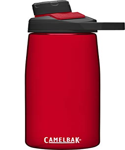

In [111]:
test_id = 8520
input_document = hyperspace_client.get_document(collection_name, test_id)
display_doc(collection_name,test_id)

In [112]:
np.array(input_document['img_clip']) @ np.array(input_document['img_clip'])

1.0

8520 === 2.0
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 25oz, Cardinal


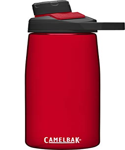

8525 === 1.918986201286316
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 25oz, Lava


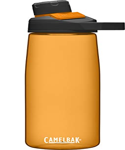

8522 === 1.9159529209136963
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 25oz, Coastal


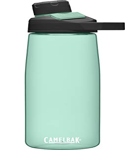

8517 === 1.8945541381835938
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 20oz, Lava


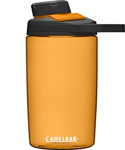

8512 === 0.983771800994873
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 20oz, Lupine


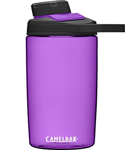

8510 === 0.9821794033050537
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 50oz, Oxford


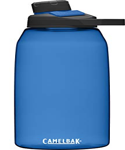

8509 === 0.9772890210151672
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 20oz, Clear


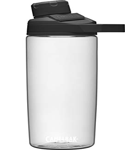

8515 === 0.975383996963501
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 50oz, Clear


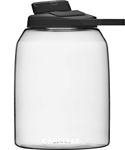

8511 === 0.9753615260124207
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 32oz, Clear


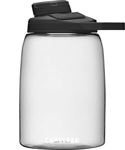

8523 === 0.9743634462356567
CamelBak Chute Mag BPA Free Water Bottle with Tritan Renew, 32oz, Charcoal


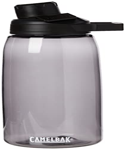

In [116]:
query_with_knn = {
    'params': input_document,
    'knn' : {
        'img_clip' : {"boost":1},
        'txt_clip' : {"boost":1},
        'query' : {'boost':0}
    }
}

results = hyperspace_client.search(query_with_knn,
                                        size=10,
                                        collection_name=collection_name)
for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    display(display_doc(collection_name,res['document_id']))

## New input similarity

### Text

38147 === 0.2329264134168625
Intex Mega Swan Ride-On Inflatable Pool Float


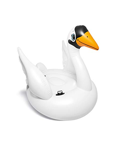

25999 === 0.21883752942085266
Intex Mega Flamingo, Inflatable Island , Pink


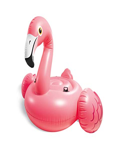

21022 === 0.21722231805324554
GUND Baby Baby Toothpick Aubrey Flamingo Plush Stuffed Animal, Pink, 16"


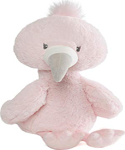

27261 === 0.21618719398975372
FOCO Denver Broncos BRXLZ Team Logo 1Z


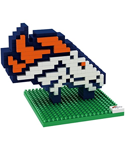

48175 === 0.21440453827381134
FOCO Michigan Wolverines NCAA BRXLZ Logo 1Z


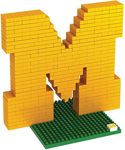

In [155]:
input_text = ["duck"]
text_vec = _emb_txt(input_text)

query_with_knn = {
    'params': {
        "img_clip" : text_vec,
        "txt_clip": text_vec
    },
    'knn' : {
        'img_clip' : {"boost":0.8},
        'txt_clip' : {"boost":0.2},
        'query' : {'boost':0}
    }
}

results = hyperspace_client.search(query_with_knn,
                                        size=5,
                                        collection_name=collection_name)
for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    display(display_doc(collection_name,res['document_id']))

### image

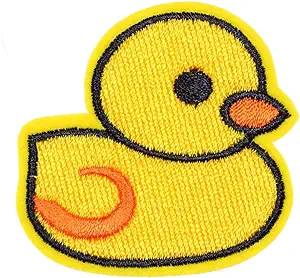

In [149]:
url = "https://m.media-amazon.com/images/I/71N80IX6mxL.__AC_SX300_SY300_QL70_FMwebp_.jpg"
im,im_emb = load_and_emb(url)
im

35836 === 0.780569851398468
GUND LINE Friends Sally Round Body Pillow Soft Plush Stuffed, Yellow, 12”


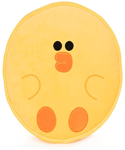

38147 === 0.7750683426856995
Intex Mega Swan Ride-On Inflatable Pool Float


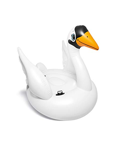

40993 === 0.768219530582428
GUND LINE Friends Squid Sally Chick Plush Stuffed Animal, 7"


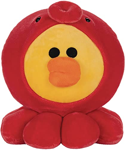

44056 === 0.7675026059150696
FINIS Manta Swim Training Hand Paddle for Competitive Swimming Exercise , Small


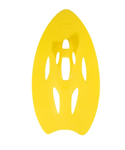

21022 === 0.7408950924873352
GUND Baby Baby Toothpick Aubrey Flamingo Plush Stuffed Animal, Pink, 16"


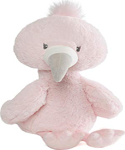

In [153]:
query_with_knn = {
    'params': {
        "img_clip" : im_emb,
        "txt_clip": im_emb
    },
    'knn' : {
        'img_clip' : {"boost":1},
        'txt_clip' : {"boost":0},
        'query' : {'boost':0}
    }
}

results = hyperspace_client.search(query_with_knn,
                                        size=5,
                                        collection_name=collection_name)
for res in results['similarity']:
    print(f"{res['document_id']} === {res['score']}")
    display(display_doc(collection_name,res['document_id']))